In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
sys.path.append('../../src/vae')
sys.path.append('../../src/dsets/gaussian_mixture')
from dset import get_dataloaders
from model import init_specific_model
from losses import Loss
from training import Trainer
from utils import plot_2d_samples, plot_2d_latent_samples, plot_traversals
import pickle as pkl
import pandas as pd
import seaborn as sns
from sim_gaussian_mixture import p, define_dataloaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
dirs = ["vary_lamPT_mu_seeds"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/local-vae/notebooks/ex_gaussian_mixture/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))

    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            model = init_specific_model(orig_dim=results_list[-1]['orig_dim'], 
                                        latent_dim=results_list[-1]['latent_dim'], 
                                        hidden_dim=results_list[-1]['hidden_dim']).to(device)
            model.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(model)
            
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## Plotting results

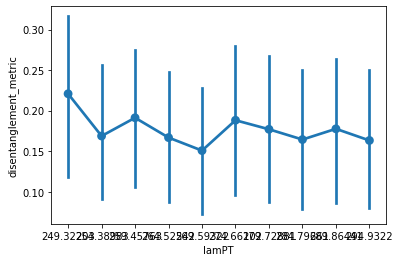

In [31]:
ax = sns.pointplot(x="lamPT", y="disentanglement_metric", hue=None, data=results[0])

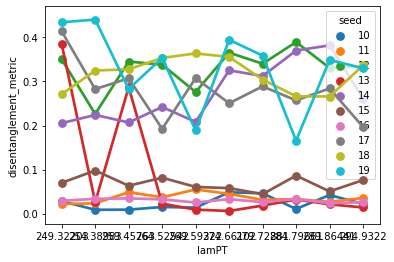

In [32]:
ax = sns.pointplot(x="lamPT", y="disentanglement_metric", hue="seed", data=results[0])